# Homework Assignment 4
Return this notebook (filled with your answers) by the deadline via mycourses. Also provide pdf printout of the notebook.

Note that the notebook that you submit needs to work. Reduction of points may be possible if it does not.

Name: **Xingji Chen** <br>
Student number: **101659554**

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Used for data generation
from scipy.stats import chi2

# These imports cover all the functionality to implement custom ensemble methods
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# These imports are used to conform to the scikit-learn API,
# you may use them if you want, but it is not necessary.
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import (
    _check_sample_weight,
    check_array,
    check_is_fitted,
    check_random_state,
    check_X_y,
)

# If fitting is slow, consider using tqdm to visualize the progress
from tqdm import tqdm

## Overview

In this assignment you will be implementing two different ensemble methods: Bagging and Boosting. In order to gain some experience in writing scikit-learn compatible estimators, you will be following the class structure and API from scikit-learn. Following the API enables you to use further functionality from scikit such as pipelines, hyperparameter optimization, preprocessing, and model selection. Furthermore, methods such as `score` can be automatically inherrited from the parent class.

You should already have some familiarity with how to fit and predict with sklearn estimators such as `LinearRegression`. Overall, what are needed in a custom estimator are an `__init__` to initialize the class instance, a `fit` to train the estimator, and a `predict` to provide predictions for new data. To get started, read scikit-learn documentation on how new estimators should be constructed [here](https://scikit-learn.org/stable/developers/develop.html).

## Data generation

In [2]:
def generate_data(num_samples, num_features):
    """Generate a random dataset for binary classification.

    Arguments:
        num_samples -- number of samples to be generated
        num_features -- number of features to be used

    Returns:
        X -- an array of shape (num_samples, num_features)
        y -- an array of shape (num_samples,)
    """
    X = np.random.normal(size=(num_samples, num_features))
    sum_of_squares = np.sum(X**2, axis=1)
    critical_value = chi2.ppf(q=0.5, df=num_features)
    y = np.ones(num_samples)
    y[sum_of_squares <= critical_value] = -1
    return X, y

In [3]:
# Set random seed such that you always get the same dataset
np.random.seed(0)
train_samples = 2000
test_samples = 10000
features = 10
X_train, y_train = generate_data(train_samples, features)
X_test, y_test = generate_data(test_samples, features)


***
# Question 1 (33p)
In this problem you will implement the **bagging algorithm** for a binary classification problem and use it to redo Figure 2.3a in the lecture notes.

In [4]:
n_estimators = 200

#### Reference implementation

In [5]:
clf_sk_bag = BaggingClassifier(n_estimators=n_estimators, random_state=42)
%time clf_sk_bag.fit(X_train, y_train)

print(f"Train accuracy: {clf_sk_bag.score(X_train, y_train):.3f}")
print(f"Test accuracy: {clf_sk_bag.score(X_test, y_test):.3f}")

CPU times: user 5.19 s, sys: 3.85 ms, total: 5.19 s
Wall time: 5.19 s
Train accuracy: 1.000
Test accuracy: 0.861


## Question 1a (23p)

Implement the missing functionality from `MyBaggingClassifier`. Break the task down into smaller steps:
1. Implement the `fit` method. The bagging algorithm for classification is described in Algorithm 2.1 of lecture notes. You only need to implement the method for the non majority vote case (i.e., largest mean probability prediction of the ensemble).
2. Implement the `predict` method. Again, implement the non majority vote case.
3. Implement the `staged_predict` method. This function should return the prediction for each iteration (i.e., a prediction for $1, 2, 3, \ldots, B$ estimators). You may either return a 2D array of shape (n_samples, n_estimators) or use the `yield` keyword to return a generator.
4. Implement the `staged_oob_score` method. This method should return the out-of-bag (OOB) training errors for each added estimator.


**Hint:** If you want to follow the scikit-learn style exactly (this is optional), use the `check_estimator` function to verify that your class implementation is done correctly.

In [6]:
class MyBaggingClassifier(ClassifierMixin, BaseEstimator):
    """Custom BaggingClassifier implementation."""

    def __init__(self, estimator=None, n_estimators=10, random_state=None):
        """Initialize the BaggingClassifier.

        Keyword Arguments:
            estimator -- base estimator used in the ensemble (default: {None})
            n_estimators -- number of estimators used in the ensembe (default: {10})
            random_state -- random state (default: {None})
        """
        self.estimator = estimator if estimator else DecisionTreeClassifier()
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X, y, verbose=False):
        """Fit the BaggingClassifier to the training data.

        Arguments:
            X -- Training data, should be array like of shape (n_samples, n_features)
            y -- Target values, should be array like of shape (n_samples,)

        Keyword Arguments:
            verbose -- enable debugging information (default: {False})

        Returns:
            self -- fitted instance of the BaggingClassifier
        """
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        self.n_features_in_ = X.shape[1]

        self.estimators_ = []
        self.oob_scores_ = []

        for i in range(self.n_estimators):
            sample_indices = self.random_state_.randint(0, len(X), len(X))
            X_sample, y_sample = X[sample_indices], y[sample_indices]
            oob_indices = np.setdiff1d(np.arange(len(X)), np.unique(sample_indices))

            estimator = clone(self.estimator)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)

            if len(oob_indices) > 0:
                oob_score = accuracy_score(y[oob_indices], estimator.predict(X[oob_indices]))
                self.oob_scores_.append(oob_score)
            else:
                # Append None or an alternative value to indicate no OOB samples were available
                self.oob_scores_.append(None)

        return self

    def predict(self, X):
        """Predict the target values for the given data.

        Arguments:
            X -- Data to predict, should be array like of shape (n_samples, n_features)

        Returns:
            array -- Predicted target values
        """
        check_is_fitted(self)
        X = check_array(X)
    
        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"X should have {self.n_features_in_} features; got {X.shape[1]}")


        # your code here
        # raise NotImplementedError("You should implement this!")
        
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])

        # Map labels to a non-negative space if necessary
        label_mapping = {label: idx for idx, label in enumerate(self.classes_)}
        inv_label_mapping = {idx: label for label, idx in label_mapping.items()}
    
        mapped_predictions = np.vectorize(label_mapping.get)(predictions)

        # Apply majority voting
        majority_vote_indices = np.apply_along_axis(lambda x: np.bincount(x, minlength=len(self.classes_)).argmax(), axis=0, arr=mapped_predictions)

        # Map the majority vote results back to the original label space
        majority_vote = np.vectorize(inv_label_mapping.get)(majority_vote_indices)

        return majority_vote
    
    def staged_predict(self, X):
        check_is_fitted(self)
        X = check_array(X)

        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"X should have {self.n_features_in_} features; got {X.shape[1]}")

        # Create a mapping from your class labels to non-negative integers
        label_to_int = {label: i for i, label in enumerate(self.classes_)}
        int_to_label = {i: label for label, i in label_to_int.items()}

        for i in range(self.n_estimators):
            predictions = np.array([est.predict(X) for est in self.estimators_[:i + 1]])

            # Map predictions to non-negative integer space
            int_predictions = np.vectorize(label_to_int.get)(predictions)

            # Now use np.bincount to get the majority vote
            majority_vote_int = np.apply_along_axis(lambda x: np.bincount(x, minlength=len(self.classes_)).argmax(), axis=0, arr=int_predictions)

            # Map integer predictions back to original class labels
            majority_vote = np.vectorize(int_to_label.get)(majority_vote_int)

            yield majority_vote


    def staged_oob_score(self):
        """Return the out-of-bag score for each estimator.

        Returns:
            array -- Out-of-bag score for each estimator
        """
        check_is_fitted(self)
        
        for score in self.oob_scores_:
            yield score
        # your code here
        # Hint, you should store the out-of-bag score for each estimator during the fit
        # and return it here. store it in a list such as `self.oob_score_`
        # raise NotImplementedError("You should implement this!")

    def _more_tags(self):
        # This method is used by scikit-learn to check capabilities
        # of the estimator. Please don't modify this method.
        return {"binary_only": True}
    

#### Optional: run the check estimator

In [7]:
#clf = MyBaggingClassifier(n_estimators=5, random_state=42)
#check_estimator(clf)

#### Fit and score the model

You should get results within approximately 5% of the reference implementation

In [8]:
clf = MyBaggingClassifier(n_estimators=n_estimators, random_state=42)
%time clf.fit(X_train, y_train)

print(f"Train accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

CPU times: user 6.32 s, sys: 2.99 ms, total: 6.32 s
Wall time: 6.32 s
Train accuracy: 1.000
Test accuracy: 0.860


## Question 1b (10p)
Use the class `MyBaggingClassifier` to redo the Figure 2.3a in the lecture notes. Some randomness is inevitable due to the sample bootstrap process, but overall deviations from the reference figure should be very small.

**Tasks:**
1. Plot the test error of a stump (i.e., a 2-leaf tree). Use the `DecisionTreeClassifier`.
2. Plot the test error of a full tree. Use the `DecisionTreeClassifier` with it's default arguments.
3. Plot the staged OOB training error. You should be able to get this from the `staged_oob_score` method.
4. Plot the staged test error. You should be able to get this from the `staged_predict` method.

In [9]:
stump = DecisionTreeClassifier(max_leaf_nodes=2).fit(X_train, y_train)
stump_error = 1 - accuracy_score(y_test, stump.predict(X_test))  
print("Stump error rate  : {:5.2f}%".format(100 * stump_error))            

node_245 = DecisionTreeClassifier(max_leaf_nodes=123).fit(X_train, y_train)
node_245_error = 1 - accuracy_score(y_test, node_245.predict(X_test))
print("245-node error error rate  : {:5.2f}%".format(100 * node_245_error))  

Stump error rate  : 45.70%
245-node error error rate  : 24.79%


In [10]:
def ooberror(X, y, n_estimators):
    forest = []
    errors = []
    bootstrapped_indices = []
    
    for i in range(n_estimators):
        tree = DecisionTreeClassifier()
        bootstrap_idx = np.random.choice(len(X), size=len(X))
        bootstrapped_indices.append(bootstrap_idx)
        
        bootstrap_X = X[bootstrap_idx]
        bootstrap_y = y[bootstrap_idx]
        
        tree.fit(bootstrap_X, bootstrap_y)
        forest.append(tree)
        
        tree_predictions = np.array([t.predict(X) for t in forest])
        
        for pred, indices in zip(tree_predictions, bootstrapped_indices):
            pred[indices] = 0
        
        oob_prediction = 2 * (np.sum(tree_predictions.T, axis=1) >= 0) - 1
        error = 1 - accuracy_score(y, oob_prediction)
        errors.append(error)
    
    return forest, errors

def testerror(trees, X, y):
    test_error = []
    
    for i in range(len(trees)):
        # Aggregate predictions from the first i+1 trees
        y_pred = 2 * (np.sum(np.array([tree.predict(X) for tree in trees[:i + 1]]).T, axis=1) >= 0) - 1
        # Calculate and store the test error
        test_error.append(1 - accuracy_score(y, y_pred))
    
    return test_error


In [11]:
n_estimators = 200

%time trees, oob_error = ooberror(X_train, y_train, n_estimators)
%time test_error = testerror(trees, X_test, y_test)

CPU times: user 11.4 s, sys: 23.3 ms, total: 11.4 s
Wall time: 11.4 s
CPU times: user 17.6 s, sys: 55.7 ms, total: 17.7 s
Wall time: 17.7 s


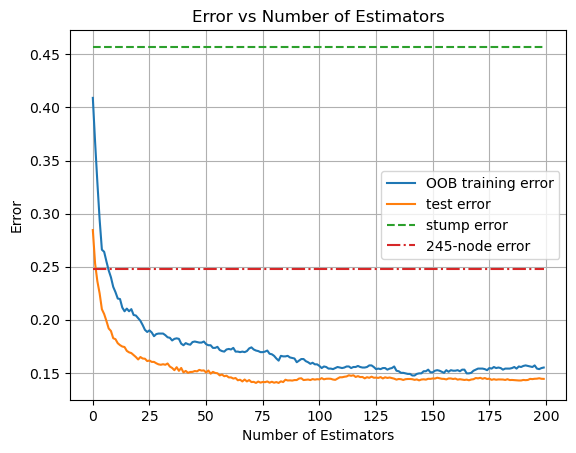

In [12]:
# Plotting
plt.grid()
plt.plot(oob_error, label='OOB training error')
plt.plot(test_error, label='test error')
plt.plot([stump_error] * n_estimators, "--", label='stump error')
plt.plot([node_245_error] * n_estimators, "-.", label='245-node error')
plt.xlabel('Number of Estimators')
plt.ylabel('Error')
plt.legend()
plt.title('Error vs Number of Estimators')
plt.show()

***
# Question 2 (23p)
In this problem you will implement the **Random Forest** algorithm for the binary classification problem and use it to redo the Figure 3.3b in the lecture notes.

In [13]:
n_estimators = 200
max_features = 2
min_samples_leaf = 3

#### Reference implementation

In [14]:
clf_sk_rf = RandomForestClassifier(
    n_estimators=n_estimators,
    max_features=max_features,
    min_samples_leaf=min_samples_leaf,
    random_state=42,
)
%time clf_sk_rf.fit(X_train, y_train)

print(f"Train accuracy: {clf_sk_rf.score(X_train, y_train):.3f}")
print(f"Test accuracy: {clf_sk_rf.score(X_test, y_test):.3f}")

CPU times: user 1.17 s, sys: 3.96 ms, total: 1.17 s
Wall time: 1.17 s
Train accuracy: 0.999
Test accuracy: 0.873


## Question 2a (13p)

Implement **Random Forest** from Algorithm 2.2 of the lecture notes. See what needs to be changed or added to the Bagging class made before. Use the given arguments for the number of estimators (200), number of features (2), and minimum samples per leaf (3). To create the base estimator, use the scikit-learn `DecisionTreeClassifier`.

In [15]:
def RandomForest(X, y, B, d, nmin):
    trees = []
    error = []
    bootstrapped = []
    
    for _ in range(B):
        tree = DecisionTreeClassifier(max_features = d, min_samples_leaf = nmin)
        
        bootstrap_idx = np.random.choice(len(X), size = train_samples)
        bootstrapped.append(bootstrap_idx)
        bootstrap_X = X[bootstrap_idx]
        bootstrap_y = y[bootstrap_idx]
        
        tree.fit(bootstrap_X, bootstrap_y)
        trees.append(tree)
        tree_preds = np.array([tree.predict(X) for tree in trees])
        
        for pred, bootstrap in zip(tree_preds, bootstrapped):
            pred[bootstrap] = 0  
            
        y_pred = 2 * (np.sum(tree_preds.T, axis=1) >= 0) - 1
        error.append(1 - accuracy_score(y, y_pred))
    
    return trees, error

#%time forest, forest_err_train = RandomForest(X_train, y_train, n_estimators, max_features, min_samples_leaf)

#### Fit and score the model

You should get results within approximately 5% of the reference implementation

In [16]:
%time clf.fit(X_train, y_train)

print(f"Train accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

CPU times: user 6.27 s, sys: 0 ns, total: 6.27 s
Wall time: 6.27 s
Train accuracy: 1.000
Test accuracy: 0.858


## Question 2b (10p)
Use your implementation of the Random Forest to redo the Figure 2.3b in the lecture notes. Some randomness is inevitable due to the sample bootstrap process, but overall deviations from the reference figure should be very small.

**Tasks:**
1. Plot the test error of a stump (i.e., a 2-leaf tree). Use the `DecisionTreeClassifier`.
2. Plot the test error of a full tree. Use the `DecisionTreeClassifier` with it's default arguments.
3. Plot the OOB training error. You should be able to get this from the `staged_oob_score` method.
4. Plot the Test error. You should be able to get this from the `staged_predict` method.

In [17]:
# your code here
%time forest, forest_err_train = RandomForest(X_train, y_train, n_estimators, max_features, min_samples_leaf)
%time forest_err_test = testerror(forest, X_test, y_test)

CPU times: user 6.83 s, sys: 23.8 ms, total: 6.85 s
Wall time: 6.86 s
CPU times: user 18.9 s, sys: 35.8 ms, total: 18.9 s
Wall time: 19 s


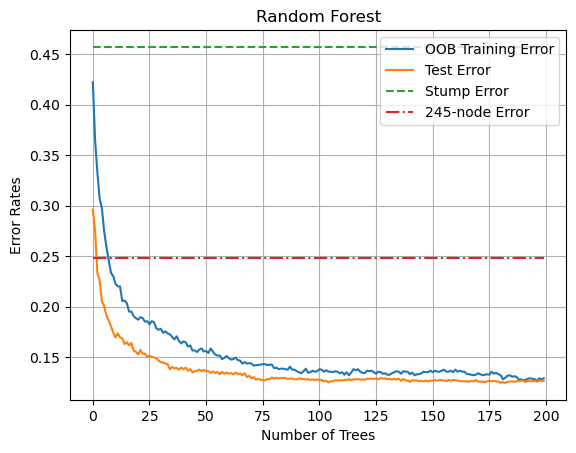

In [18]:
plt.grid()
plt.xlabel("Number of Trees")
plt.ylabel("Error Rates")
plt.plot(forest_err_train)
plt.plot(forest_err_test)
plt.plot([stump_error] * n_estimators, "--", label='stump error')
plt.plot([node_245_error] * n_estimators, "-.", label='245-node error')
plt.legend(["OOB Training Error", "Test Error", "Stump Error","245-node Error"], loc=1)
plt.title("Random Forest")
plt.show()

***
# Question 3 (44p)
In this problem you will implement the **Adaboost.M1 algorithm** and use it to redo Figure 3.1a and Figure 3.3a.

In [19]:
n_estimators = 600

#### Reference implementation

In [20]:
clf_sk_ada_m1 = AdaBoostClassifier(n_estimators=n_estimators, algorithm="SAMME")
%time clf_sk_ada_m1.fit(X_train, y_train)

print(f"Train accuracy: {clf_sk_ada_m1.score(X_train, y_train):.3f}")
print(f"Test accuracy: {clf_sk_ada_m1.score(X_test, y_test):.3f}")

CPU times: user 2.43 s, sys: 51 µs, total: 2.43 s
Wall time: 2.43 s
Train accuracy: 0.961
Test accuracy: 0.897


##  Question 3a (20p)

Implement the missing functionality from `MyAdaBoostM1Classifier`. Break the task down into smaller steps:
1. Implement the `fit` method. The boosting algorithm for classification is described in Algorithm 3.1 of lecture notes.
2. Implement the `predict` method.
3. Implement the `staged_predict` method. This function should return the prediction for each iteration (i.e., a prediction for $1, 2, 3, \ldots, B$ estimators). You may either return a 2D array of shape (n_samples, n_estimators) or use the `yield` keyword to return a generator.
4. Implement the `predict_proba` method. This function should return the probabilities for each sample belonging to that class. The algorithm for this is described in subsection 3.4.


**Hint:** If you want to follow the scikit-learn development exactly (this is optional), use the `check_estimator` function to verify that your class implementation is done correctly.

In [21]:
class MyAdaBoostM1Classifier(ClassifierMixin, BaseEstimator):
    """Custom AdaBoostM1Classifier implementation."""

    def __init__(self, estimator=None, n_estimators=50, random_state=None):
        """Initialize the AdaBoostM1Classifier.

        Keyword Arguments:
            estimator -- base estimator used in the ensemble (default: {None})
            n_estimators -- number of estimators used in the ensembe (default: {50})
            random_state -- random state (default: {None})
        """
        super().__init__()
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimator = estimator

    def fit(self, X, y, verbose=False):
        """Fit the AdaBoostM1Classifier to the training data.

        Arguments:
            X -- Training data, should be array like of shape (n_samples, n_features)
            y -- Target values, should be array like of shape (n_samples,)

        Keyword Arguments:
            verbose -- enable debugging information (default: {False})

        Returns:
            self -- fitted instance of the AdaBoostM1Classifier
        """
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        
        self.n_features_in_ = X.shape[1]
        self.estimators_ = []
        self.estimator_weights_ = []
        self.estimator_errors_ = []
        
        n_samples = X.shape[0]
        sample_weight = np.full(n_samples, 1 / n_samples)
        
        for iboost in range(self.n_estimators):
            # Fit a classifier with the specific weights
            estimator = clone(self.estimator)
            estimator.fit(X, y, sample_weight=sample_weight)
            y_pred = estimator.predict(X)

            # Calculate error and alpha (estimator weight)
            incorrect = (y_pred != y)
            estimator_error = np.mean(np.average(incorrect, weights=sample_weight, axis=0))
            
            # Boost alpha for the classifier
            alpha = np.log((1 - estimator_error) / estimator_error) + np.log(len(self.classes_) - 1)

            # Update weights
            sample_weight *= np.exp(alpha * incorrect)
            sample_weight /= np.sum(sample_weight)

            # Save the current estimator
            self.estimators_.append(estimator)
            self.estimator_weights_.append(alpha)
            self.estimator_errors_.append(estimator_error)

        # your code here
        # raise NotImplementedError("You should implement this!")

        return self

    def predict(self, X):
        """Predict the target values for the given data.

        Arguments:
            X -- Data to predict, should be array like of shape (n_samples, n_features)

        Returns:
            array -- Predicted target values
        """
        check_is_fitted(self)
        X = check_array(X)
        if X.shape[1] != self.n_features_in_:
            raise ValueError(
                f"X should have {self.n_features_in_} features; got {X.shape[1]}"
            )
        
        # your code here
        # raise NotImplementedError("You should implement this!")
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        weighted_predictions = np.average(predictions, weights=self.estimator_weights_, axis=0)
        y_pred = np.sign(weighted_predictions)

        return y_pred


    def predict_proba(self, X):
        """Predict the target probabilities for the given data.

        Arguments:
            X -- Data to predict, should be array like of shape (n_samples, n_features)

        Returns:
            array -- Predicted target probabilities
        """
        check_is_fitted(self)
        X = check_array(X)
        if X.shape[1] != self.n_features_in_:
            raise ValueError(
                f"X should have {self.n_features_in_} features; got {X.shape[1]}"
            )

        # your code here
        # raise NotImplementedError("You should implement this!")
        # Compute probabilities
        proba = sum(estimator.predict(X) * w for estimator, w in zip(self.estimators_, self.estimator_weights_))
        
        # Transform to probability distribution
        proba = np.exp(proba)
        proba /= np.sum(proba, axis=1, keepdims=True)

        return proba

    def staged_predict(self, X):
        """Predict the target values for the given data in stages for each estimator.

        Arguments:
            X -- Data to predict, should be array like of shape (n_samples, n_features)

        Returns:
            array -- Predicted target values for each estimator
        """
        check_is_fitted(self)
        X = check_array(X)
        if X.shape[1] != self.n_features_in_:
            raise ValueError(
                f"X should have {self.n_features_in_} features; got {X.shape[1]}"
            )

        # your code here
        # raise NotImplementedError("You should implement this!")
        for i, estimator in enumerate(self.estimators_):
            # Sum the predictions up to the i-th estimator
            predictions = np.array([est.predict(X) for est in self.estimators_[:i + 1]])
            weighted_predictions = np.average(predictions, weights=self.estimator_weights_[:i + 1], axis=0)
            y_pred = np.sign(weighted_predictions)
            yield y_pred

    def _more_tags(self):
        return {"binary_only": True}

#### Optional: run the check estimator

In [22]:
#clf = MyAdaBoostM1Classifier(n_estimators=10)
#check_estimator(clf)

#### Fit and score the model

You should get results within approximately 5% of the reference implementation

In [23]:
base_clf = DecisionTreeClassifier(max_depth=1)
clf = MyAdaBoostM1Classifier(base_clf, n_estimators=n_estimators)
%time clf.fit(X_train, y_train)

print(f"Train accuracy: {clf.score(X_train, y_train):.3f}")
print(f"Test accuracy: {clf.score(X_test, y_test):.3f}")

CPU times: user 2.26 s, sys: 10 µs, total: 2.26 s
Wall time: 2.26 s
Train accuracy: 0.961
Test accuracy: 0.897


## Question 3b (10p)
Use the class `MyAdaBoostM1Classifier` to redo the Figure 3.1a in the lecture notes.

**Tasks:**
1. Plot the test error of a stump (i.e., a 2-leaf tree). Use the `DecisionTreeClassifier`.
2. Plot the test error of a full tree. Use the `DecisionTreeClassifier` with it's default arguments.
3. Plot the Training error. You should be able to get this from the `staged_predict` method.
4. Plot the Test error. You should be able to get this from the `staged_predict` method.

In [24]:
M = 600
node = 2

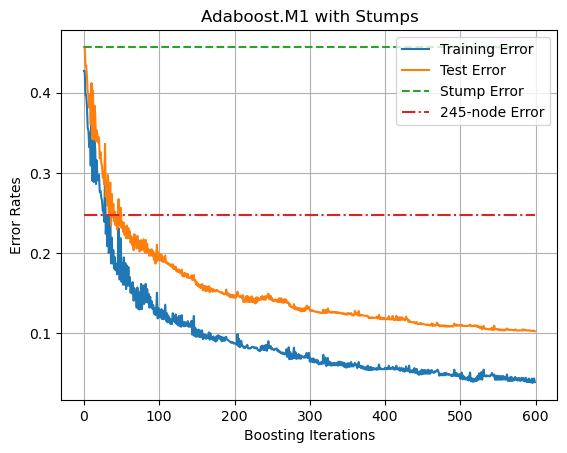

In [25]:
def AdaBoostM1(X, y, M, node):
    G = []
    w = np.array([1/y.shape[0]] * y.shape[0])
    alphas = []
    
    for _ in range(M):
        tree = DecisionTreeClassifier(max_leaf_nodes=node)
        tree.fit(X, y, sample_weight = w)
        
        y_pred = tree.predict(X)
        error_m = np.sum(np.where(y != y_pred, w, 0))/np.sum(w)
        alpha_m = np.log((1 - error_m) / error_m)
        w = np.where(y != y_pred, w * np.exp(alpha_m), w)
        
        alphas.append(alpha_m)
        G.append(tree)
    
    return G, alphas

def PredAdaBoostM1(G, alphas, X, y): 
    s = np.zeros(len(y))
    label = []
    error = []
    
    for stump, alpha in zip(G, alphas):
        s += alpha * stump.predict(X)
        y_pred = np.sign(s)
        label.append(y_pred)
        error.append(1 - accuracy_score(y, y_pred))
    
    return label, error

G, alphas = AdaBoostM1(X_train, y_train, M, node)
label_train, ada_train_error = PredAdaBoostM1(G, alphas, X_train, y_train)
label_test, ada_test_error = PredAdaBoostM1(G, alphas, X_test, y_test)

plt.grid()
plt.plot(ada_train_error)
plt.plot(ada_test_error)
plt.xlabel("Boosting Iterations")
plt.ylabel("Error Rates")
plt.plot([stump_error] * M, "--")
plt.plot([node_245_error] * M, "-.")
plt.legend(["Training Error", "Test Error", "Stump Error","245-node Error"], loc=1)
plt.title("Adaboost.M1 with Stumps")
plt.show()

## Question 3c (14p)
Use the class `MyAdaBoostM1Classifier` to redo the Figure 3.3a in the lecture notes.

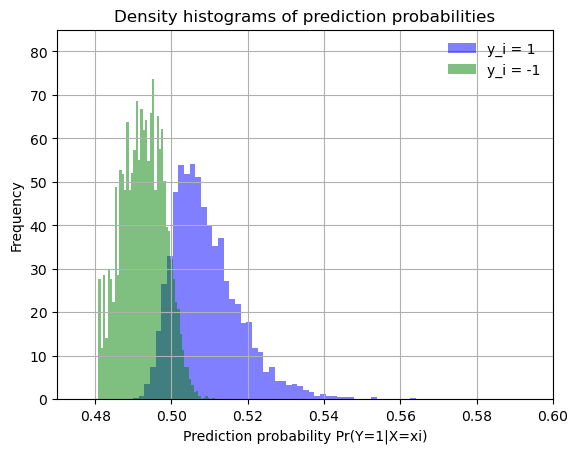

In [27]:
# your code here

def Prob(G, alphas, X):
    sum_alphas = sum(alphas) 
    M = len(G)
    N = X.shape[0]
    sum_fx = np.zeros(N)
    for i in range(M):
        ypred = G[i].predict(X)
        sum_fx += alphas[i] * ypred
    fx = sum_fx/sum_alphas
    prob = 1/(1 + np.exp(-fx))
    return prob

# Normalize
kwargs = dict(alpha=0.7, bins=50,density=True,stacked=True)

G, alphas = AdaBoostM1(X_train, y_train, M, 2)
prob = Prob(G, alphas, X_test)
probs1 = []
probsminus1 = []
for (index, label) in enumerate(y_test):
    if label == 1:
        probs1.append(prob[index])
    else:
        probsminus1.append(prob[index])

plt.title("Density histograms of prediction probabilities")

plt.hist(probs1, alpha=0.5, bins=50,density=True,stacked=True, label = "y_i = 1", color="blue")
plt.hist(probsminus1, alpha=0.5, bins=50,density=True,stacked=True, label = "y_i = -1", color="green")
plt.ylim([0,85])
plt.xlim([0.47, 0.60])
plt.xlabel("Prediction probability Pr(Y=1|X=xi)")
plt.ylabel("Frequency")
plt.legend(loc=1, frameon=False)
plt.grid()

***
# Question 4 (BONUS +10p)

This problem is **optional** and will grant you bonus points. The goal is to run Adaboost.M1 with small neural networks as estimators. You do not need a GPU to complete this task, and total training time is less than a few minutes on a low-end laptop. The neural network must be implemented with PyTorch, as scikit-learn doens't provide sample weighting necessary for boosting.

### Additional Imports

In [28]:
import torch
from torch import nn
import torch.nn as nn

## Question 4a (3p)

As the base estimator, use a Multilayer Perceptron (MLP). The model should consist of two linear layers with ReLU activation and a sigmoid output. Fill in the initialization and and `forward` methods. If Deep Learning is new to you, or you are unfamiliar with PyTorch, [this](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html) guide should covers the basics on models. The model should look as follows:



![MLP figure](figures/mlp.svg)

In [29]:
class MLP(nn.Module):
    """Custom MLP implementation."""

    def __init__(self, input_dim, hidden_dim, output_dim, random_state=0):
        """Initialize the MLP.

        Arguments:
            input_dim -- input dimension
            hidden_dim -- hidden dimension
            output_dim -- output dimension

        Keyword Arguments:
            random_state -- random state (default: {0})
        """
        super().__init__()
        torch.manual_seed(random_state)

        # your code here
        # raise NotImplementedError("You should implement this!")
        # Define the first linear layer
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        
        # Define the second linear layer
        self.linear2 = nn.Linear(hidden_dim, output_dim)

        # Define ReLU activation for hidden layer
        self.relu = nn.ReLU()

        # Define Sigmoid activation for output layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """Forward pass of the MLP.

        Arguments:
            x -- input data

        Returns:
            tensor -- output data
        """
        # your code here
        # raise NotImplementedError("You should implement this!")
        # Pass data through linear1
        x = self.linear1(x)
        
        # Apply ReLU activation function
        x = self.relu(x)
        
        # Pass data through linear2
        x = self.linear2(x)
        
        # Apply Sigmoid activation function
        output = self.sigmoid(x)
        
        return output

#### Check the model implementation

In [30]:
base_clf = MLP(input_dim=features, hidden_dim=32, output_dim=1)

# check that the model returns the correct output shape
X = torch.rand(32, features)
y = base_clf(X)
assert y.shape == (32, 1)

# check that the model has the correct number of parameters
# -> (2 weight matrices and 2 bias vectors)
assert len(list(base_clf.parameters())) == 4

## Question 4b (4p)
Implement the `MLPClassifier` as a scikit-learn estimator. Initialize and train the MLP in the `fit` method. An overview of the training loop is provided [here](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html). Use the provided Adam optimizer and Binary Cross-Entropy (BCE) loss functions.

The key part for Adaboost.M1 is the per sample weighting. To be able to do this, our fit method must accept a `sample_weight` argument. During training, multiply the (unreduced) loss with the weights before averaging. The process is illustarted in the following figure:

![training with weights](figures/weighted_training.svg)

In [31]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.validation import _check_sample_weight

class MLPClassifier(ClassifierMixin, BaseEstimator):
    """Custom MLPClassifier implementation."""

    def __init__(self, random_state=None, hidden_dim=32, learning_rate=1e-3, n_epoch=10, batch_size=64):
        """Initialize the MLPClassifier."""
        self.random_state = random_state
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.n_epoch = n_epoch
        self.batch_size = batch_size

    def fit(self, X, y, sample_weight=None):
        """Fit the MLPClassifier to the training data."""
        if self.random_state is not None:
            torch.manual_seed(self.random_state)

        X, y = check_X_y(X, y, ensure_min_samples=2, dtype=None)
        y = (y > 0).astype(int)  # Ensure y is binary

        self.classes_ = unique_labels(y)
        self.n_features_in_ = X.shape[1]

        if sample_weight is None:
            sample_weight = np.ones(X.shape[0])

        sample_weight = _check_sample_weight(sample_weight, X, dtype=np.float64)

        self.model_ = MLP(input_dim=self.n_features_in_, hidden_dim=self.hidden_dim, output_dim=1)

        criterion = nn.BCEWithLogitsLoss(reduction='none')
        optimizer = torch.optim.Adam(self.model_.parameters(), lr=self.learning_rate)

        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        sample_weight_tensor = torch.tensor(sample_weight, dtype=torch.float32).view(-1, 1)

        dataset = TensorDataset(X_tensor, y_tensor, sample_weight_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.n_epoch):
            for X_batch, y_batch, sw_batch in dataloader:
                optimizer.zero_grad()
                outputs = self.model_(X_batch)
                loss = criterion(outputs, y_batch)
                loss = (loss * sw_batch).mean()
                loss.backward()
                optimizer.step()

        return self

    def predict(self, X):
        """Predict the target values for the given data."""
        check_is_fitted(self)
        X = check_array(X)
        if X.shape[1] != self.n_features_in_:
            raise ValueError(f"X should have {self.n_features_in_} features; got {X.shape[1]}")

        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model_.eval()
        with torch.no_grad():
            outputs = self.model_(X_tensor)
        predictions = (torch.sigmoid(outputs) >= 0.5).int().numpy().flatten()
        return predictions

    def _more_tags(self):
        return {"binary_only": True, "poor_score": True}


#### Optional: run the check estimator

In [32]:
#base_clf = MLPClassifier(hidden_dim=32, n_epoch=100)
#check_estimator(base_clf)

#### Check that the MLP classifier learns something

You should have around 60% Train accuracy after 10 epochs

In [33]:
base_clf = MLPClassifier(hidden_dim=32, n_epoch=10)
%time base_clf.fit(X_train, y_train)

print(f"Train accuracy: {base_clf.score(X_train, y_train):.3f}")
print(f"Test accuracy: {base_clf.score(X_test, y_test):.3f}")

CPU times: user 1.81 s, sys: 95.9 ms, total: 1.91 s
Wall time: 815 ms
Train accuracy: 0.490
Test accuracy: 0.495


## Question 4c (2p)

Train the Adaboost.M1 ensemble with the `MLPClassifier` as the base estimator. Use the default parameters for the MLP. Compute the train and test errors. You should reach a test accuracy of nearly 90 %.

In [37]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

mlp_base = MLPClassifier(n_epoch=50)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', AdaBoostClassifier(base_estimator=mlp_base, algorithm='SAMME', n_estimators=50))
])

pipeline.fit(X_train, y_train)

train_accuracy = pipeline.score(X_train, y_train)
test_accuracy = pipeline.score(X_test, y_test)

print(f"Train accuracy: {train_accuracy:.3f}")
print(f"Test accuracy: {test_accuracy:.3f}")


/opt/software/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


ValueError: BaseClassifier in AdaBoostClassifier ensemble is worse than random, ensemble can not be fit.

## Question 4d (1p)

Plot the convergence plot and probability histograms for the MLP based Adaboost classifier (i.e. create the figures from Q3b and Q3c for the new classifier).

In [38]:
# your code here (error vs. iteration plot)
import matplotlib.pyplot as plt

# Extracting the errors from the AdaBoost classifier
ada_errors = ada_boost.estimator_errors_

# Plotting the convergence plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ada_errors) + 1), ada_errors, marker='o')
plt.xlabel('Number of Iterations')
plt.ylabel('Error')
plt.title('Error vs. Iterations for the MLP-based AdaBoost Classifier')
plt.show()

NameError: name 'ada_boost' is not defined

In [36]:
# your code here (probability histogram)
# Obtain the predicted probabilities
y_test_prob = ada_boost.predict_proba(X_test)[:, 1]

# Plot the probability histogram
plt.figure(figsize=(10, 6))
plt.hist(y_test_prob, bins=10, alpha=0.7)
plt.title('Probability Histogram for the MLP-based AdaBoost Classifier')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


NameError: name 'ada_boost' is not defined